In [1]:
import numpy as np
import torch
from torch import optim
import os
import sys
sys.path.append('C:\\Users\\chris\\Desktop\\Masterarbeit\\code')
from utils.dataloader import train_val_loader, test_loader
from networks.cnn import CNN_pool, CNN_var
from networks.tests import CNN_bernstein
import matplotlib.pyplot as plt
import pyreadr
from scipy.integrate import quad
import scipy as sc

In [2]:
def bernstein_polynomial(h, i, d):
    res = sc.special.comb(d,i)*np.power(h,i)*np.power((1-h), (d-i))
    return res

In [3]:
def get_bernstein_polynomials(h, degree, coeff = None):
    d = np.arange(0,(degree+1))
    res = np.array(list(map(lambda x: bernstein_polynomial(h, x, degree), d)))
    if coeff is None:
        return res
    else:
        return np.matmul(coeff, res)

In [16]:
def corr_func(h, method, r, s):
    if method=="brown":
        res = np.power((h/r),s)
    elif method=="powexp":
        res = np.exp(-np.power((h/r),s))        
    elif method == "whitmat":
        res = np.power(2, float(1-s))/sc.special.gamma(s)*\
              np.power((h/r),2)*sc.special.kv(s, (h/r))
    return res    

In [5]:
def extremal_coefficient(h, method, r, s):
    if method=="brown":
        res = 2*sc.stats.norm.cdf(np.sqrt(corr_func(h, method, r, s))/2,loc = 0, scale = 1)    
    else:
        res = 1+np.sqrt(1-corr_func(h, method, r, s)/2)        
    return res    

C:\Users\chris\AppData\Local\Temp\ipykernel_12444\731761662.py:7: RuntimeWarning: invalid value encountered in multiply
  res = np.power(2, float(1-s))/sc.special.gamma(s)*\


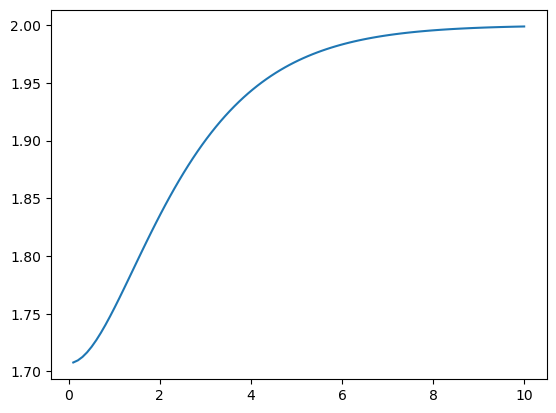

In [41]:
x = np.linspace(0,10,100)
y = extremal_coefficient(x, "whitmat", 1.2, 2)
plt.plot(x,y)

In [6]:
x = np.linspace(0,1,100)
y = get_bernstein_polynomials(x, 10)

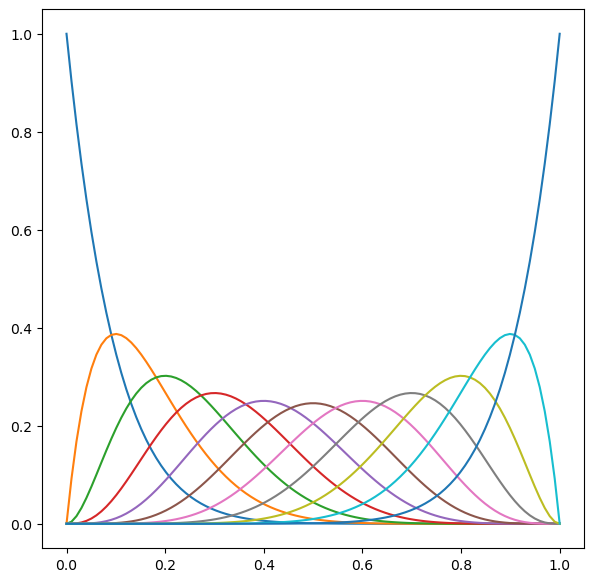

In [7]:
fig, axs = plt.subplots(figsize = (7,7))
for i in range(11):
    axs.plot(x, y[i,])

In [8]:
coef = np.random.uniform(0,1,11)
func = get_bernstein_polynomials(x, 10, coef)

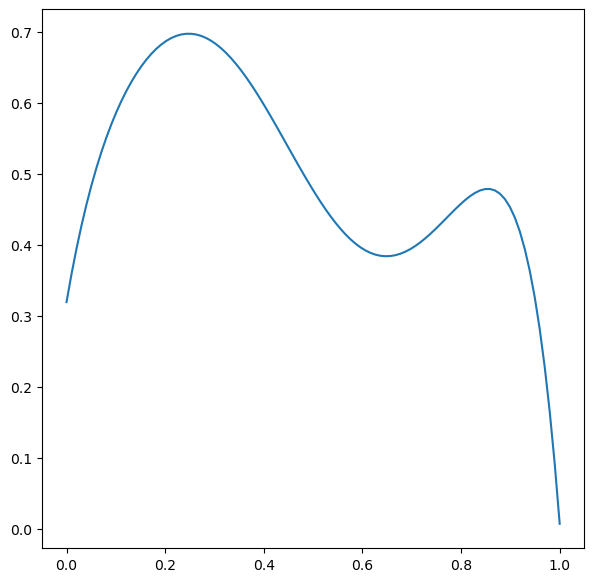

In [9]:
fig, axs = plt.subplots(figsize = (7,7))
axs.plot(x, func)

# Test Network results

In [10]:
def retransform(params):
    result = np.zeros(shape = params.shape)
    #result[:, 0] = -(1/0.25)*np.log(params[:,0])
    result[:,0] = np.exp(params[:,0])
    result[:,1] = params[:,1]*2
    return result  

In [11]:
def error_function(h, model, coeff, params, deg):
    r = params[0]
    s = params[1]
    error = np.power(extremal_coefficient(h, model, r, s) - get_bernstein_polynomials(h, deg, coeff),2)
    return error

In [12]:
def get_imse(data, model, deg):
    param = data[0:2]
    coeff = data[2:]
    error, _ = quad(error_function, 0, 1, args = (model, coeff, param, deg))
    return error

In [13]:
def get_metrics(pred, param, model):
    rmse = np.sqrt(np.mean((np.power(pred-param,2)), axis = 0))
    mae = np.mean(np.abs(pred-param), axis = 0)
    bias = np.mean(pred-param, axis = 0)
    imse_corr = np.mean(np.array([get_imse(x, model, "corr") for x in np.append(pred, param, axis = 1)]))
    imse_ext = np.mean(np.array([get_imse(x, model, "ext") for x in np.append(pred, param, axis = 1)]))
    
    
    print(f"RMSE: {np.round(rmse,2)}")
    print(f"MAE: {np.round(mae,2)}")
    print(f"Corr - IMSE: {np.round(imse_corr,2)}")    
    print(f"Ext - IMSE: {np.round(imse_ext,4)}")
    
    #print(f"Bias: {np.round(bias,2)}")

In [109]:
# Dataloader
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
exp = "exp_4"
path = f"../data/{exp}/data/"
model = "whitmat"
dataloader, _ = test_loader(data_path = path, model = model, batch_size = 750)

In [110]:
#Load model
deg = 12
net = CNN_bernstein(device = device, d = deg)
net.load_state_dict(torch.load(f"../test.pt"))

<All keys matched successfully>

In [111]:
for sample in dataloader:
    img, param = sample
    break 
net.eval()
pred = net(img).to(device)
#pred = net.increments(pred)
pred = pred.detach().cpu().numpy()
param = param.detach().numpy()
param = retransform(param)

In [112]:
#Define evaluation horizon
h = np.linspace(0.0001,1,100)

In [113]:
func_pred = get_bernstein_polynomials(h, deg, pred)

In [114]:
func_true = np.zeros(shape = func_pred.shape)
for i in range(func_true.shape[0]):
    func_true[i] = extremal_coefficient(h*40, model, param[i,0], param[i,1])

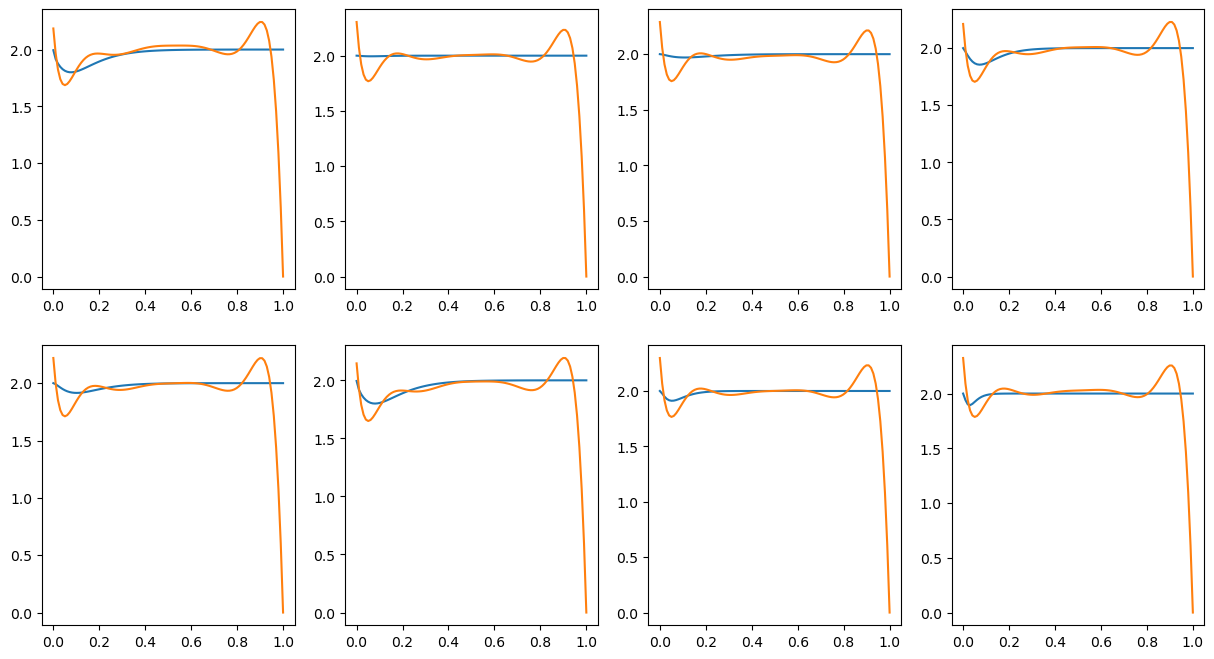

In [115]:
samples = np.random.randint(0, func_true.shape[0], 8)

fig, axs = plt.subplots(2,4, figsize = (15,8))
axs = axs.ravel()
for i, sample in enumerate(samples):
    axs[i].plot(h, func_true[sample])
    axs[i].plot(h, func_pred[sample])

In [ ]:
imse = np.mean(np.array([get_imse(x, model, deg) for x in np.append(param, pred, axis = 1)]))
imse